In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
df1 = pd.read_csv('../house_prices_reduced.csv')

In [6]:
df1.head()

,Id,LotArea,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtQual,BsmtCond,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleCondition,SalePrice,SaleType
0,1,8450,CollgCr,2Story,7,5,2003,2003,Gd,TA,...,0,0,0,NaN,NaN,2,2008,Normal,208500,WD
1,2,9600,Veenker,1Story,6,8,1976,1976,Gd,TA,...,0,0,0,NaN,NaN,5,2007,Normal,181500,WD
2,3,11250,CollgCr,2Story,7,5,2001,2002,Gd,TA,...,0,0,0,NaN,NaN,9,2008,Normal,223500,WD
3,4,9550,Crawfor,2Story,7,5,1915,1970,TA,Gd,...,0,0,0,NaN,NaN,2,2006,Abnorml,140000,WD
4,5,14260,NoRidge,2Story,8,5,2000,2000,Gd,TA,...,0,0,0,NaN,NaN,12,2008,Normal,250000,WD


# 3.1. Handling Outliers

In this dataset we will try to observe the impacts of 3 different and most commonly used ways to deal with outliers.  
Once we have our first metrics from our model, we will try with different features and different outlier methods to reach a better model

**Trimming:**  
Trimming involves removing data points that are considered outliers based on a predetermined threshold.  
These extreme values are simply discarded from the dataset.  
**Advantages:**  Simple and easy to implement. Preserves the original dataset structure.  
**Disadvantages:** May result in loss of potentially valuable information. Not always the best approach if the outliers contain meaningful insights.

**Winsorizing:**  
Winsorizing is a technique that involves capping extreme values at a specified percentile (e.g., 1st and 99th percentile).  
Values beyond this range are replaced with the nearest data point within the range.  
**Advantages:** Preserves the data distribution to a certain extent. Reduces the influence of outliers without complete removal.  
**Disadvantages:** May still lead to information loss, especially if a large portion of data is concentrated at the extremes.  
  
**Transformations (e.g., Log or Square Root):**  
Transformations involve applying a mathematical function (e.g., logarithm, square root) to the data.  
These transformations can compress the range of extreme values, making them less influential in the analysis.  
**Advantages:** Can effectively reduce the impact of outliers. Maintains the integrity of the dataset structure.  
**Disadvantages:** Interpretability of transformed data may be more challenging. The choice of transformation should be guided by domain knowledge.

In [30]:
import math

class FatihOutliers:
    '''
    There are various methods in this class to deal with outliers.
    instantiate the class with a dataframe such as:
    outlier_handler = FatihOutliers(df)
    '''
    
    def __init__(self, df) :
        self.df = df
        self.numeric_column_name_list = df.select_dtypes(include='number').columns
    
    def calculate_IQR(self, col):
        '''
        It takes a column name and returns IQR as a float
        '''
        Q1 = self.df[col].quantile(.25)
        Q3 = self.df[col].quantile(.75)
        IQR = Q3 - Q1
        return IQR
    
    def show_outliers_for_features(self, col, method='IQR', IQR_multi=3, treshold_high=0.99, treshold_low=0.01):
        '''
        return a dataframe from all outliers in selected column
        df is already given to object instance, and this method will take a column name
        methods are 'IQR' and 'tresholds' otherwise raise ValueError
        Defaults ---> method='IQR' | IQR_multi=3  |  treshold_high=0.99  |  treshold_low=0.01
        '''
        if method == 'IQR':
            IQR = self.calculate_IQR(col)
            lower_bound = self.df[col].quantile(0.25) - IQR_multi * IQR
            upper_bound = self.df[col].quantile(0.75) + IQR_multi * IQR
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            return outliers
        
        elif method == 'tresholds':
            treshold_upper = self.df[col].quantile(treshold_high) 
            treshold_lower = self.df[col].quantile(treshold_low)
            outliers = self.df[(self.df[col] < treshold_lower) | (self.df[col] > treshold_upper)]
            return outliers
            
        else:
            raise ValueError(f"Invalid method. Supported methods: 'IQR' or 'tresholds'")
        if len(outliers)==0:
            return f'There are no outliers in {col} feature'
        
        
    def show_all_outliers(self, method='IQR', IQR_multi=3, treshold_high=0.99, treshold_low=0.01):
        '''
        return a dataframe with all outlier observations in given dataframe
        df is already given to object instance
        methods are 'IQR' and 'tresholds' otherwise raise ValueError
        Defaults ---> method='IQR' | IQR_multi=3  |  treshold_high=0.99  |  treshold_low=0.01
        '''

        outliers_dict = {}
        for col in self.numeric_column_name_list:
            outliers = self.show_outliers_for_features(col, method, IQR_multi, treshold_high, treshold_low)
            if not outliers.empty:
                outliers_dict[col] = outliers
        
        if outliers_dict:
            all_outliers_df = pd.concat(outliers_dict.values(), axis=0)
            all_outliers_df.drop_duplicates(inplace=True)
            return all_outliers_df
        else:
            return None
    
    def show_outlier_stats(self, method='IQR', IQR_multi=3, treshold_high=0.99, treshold_low=0.01):
        '''
        return a dataframe with existing outlier statistics
        df is already given to object instance
        methods are 'IQR' and 'tresholds' otherwise raise ValueError
        Defaults ---> method='IQR' | IQR_multi=3  |  treshold_high=0.99  |  treshold_low=0.01
        '''
        
        outlier_stats_dict = {}
        for col in self.numeric_column_name_list:
            outliers = self.show_outliers_for_features(col, method, IQR_multi, treshold_high, treshold_low)
            if len(outliers)>0:
                outlier_stats_dict[col] = len(outliers)
        
        outlier_stats_df = pd.DataFrame({'OutlierCount': outlier_stats_dict})
        total_row = pd.DataFrame({'OutlierCount': {'Total':np.sum(outlier_stats_df.OutlierCount)}})
        outlier_stats_df = pd.concat([outlier_stats_df, total_row])
        return outlier_stats_df

    
    def plot_boxplots_for_all_numeric(self): 
        numeric_df = self.df.select_dtypes(include='number')
        qty_numeric_features = len(self.numeric_column_name_list)
        ncols  = 5
        nrows = math.ceil(qty_numeric_features/ncols) 
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(15, 25))
        axes = axes.flatten()  # this code transform axis from 2D to 1D 

        # Iterate through the columns and create box plots
        for i, col in enumerate(numeric_df.columns):
            numeric_df[col].plot.box(ax=axes[i])
            axes[i].set_title(col)

        # Hide any remaining empty subplots
        for i in range(len(numeric_df.columns), len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
        
    def plot_dtl_hist(self, col, IQR_multi=3, vline1=0.01, vline2=0.99):
        # Calculate statistics
        mean = self.df[col].mean()
        std = self.df[col].std()
        skewness = self.df[col].skew()
        percentiles = self.df[col].quantile([vline1, vline2])

        # Create histogram
        plt.figure(figsize=(15, 4))
        sns.histplot(self.df[col], kde=True)

        # Add vertical dashed lines at specified percentiles
        plt.axvline(x=percentiles[vline1], color='r', linestyle='--', label=f'{vline1*100}th percentile')
        plt.axvline(x=percentiles[vline2], color='g', linestyle='--', label=f'{vline2*100}th percentile')
        plt.axvline(x=self.df[col].quantile[0.25], color='b', linestyle='--', label=f'{0.25*100}th percentile')
        

        # Add text annotations
        plt.text(0.7, 0.9, f'Mean: {mean:.2f}', transform=plt.gca().transAxes)
        plt.text(0.7, 0.8, f'Standard Deviation: {std:.2f}', transform=plt.gca().transAxes)
        plt.text(0.7, 0.7, f'Skewness: {skewness:.2f}', transform=plt.gca().transAxes)

        # Set plot title and labels
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Add legend
        plt.legend()

        # Show the plot
        plt.show()

In [31]:
a = FatihOutliers(df1)

TypeError: 'method' object is not subscriptable

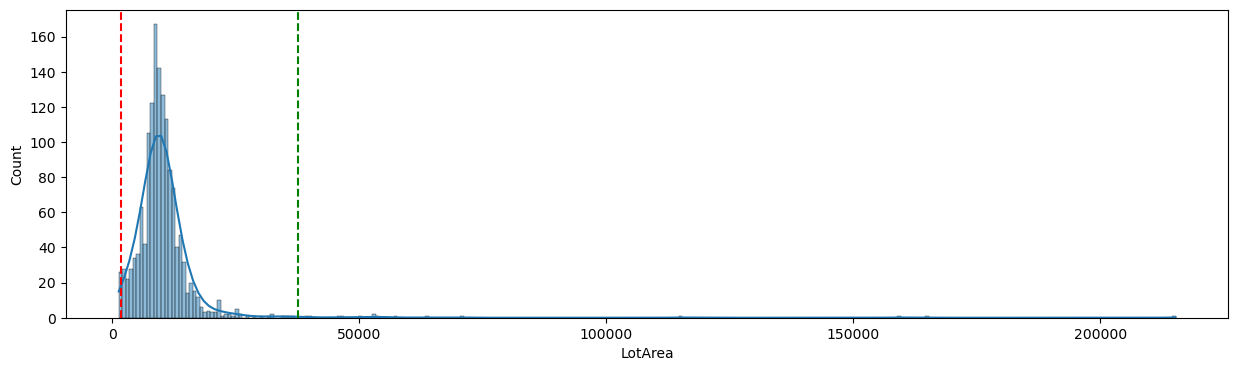

In [32]:
a.plot_dtl_hist('LotArea')

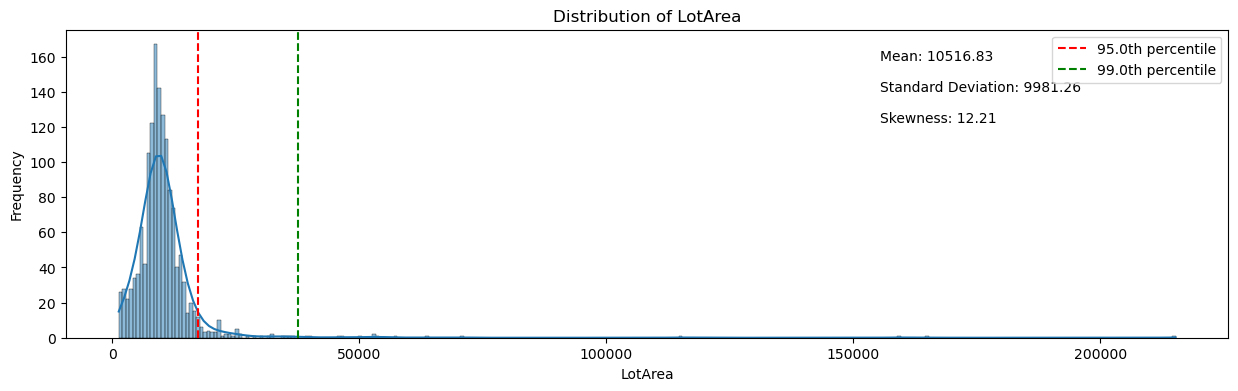

In [47]:
plot_dtl_hist(df1, 'LotArea', .95, .99)

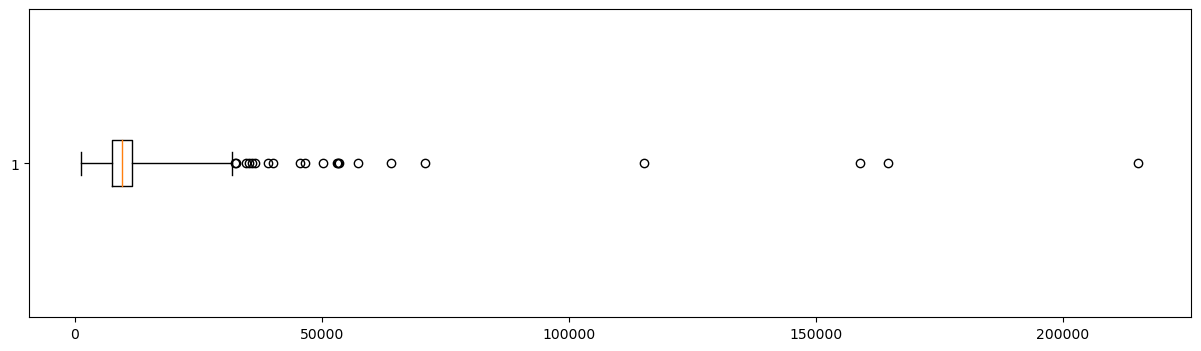

In [56]:
fig, axes = plt.subplots(figsize=(15,4))
axes.boxplot(df1.LotArea, vert=False, whis=5);

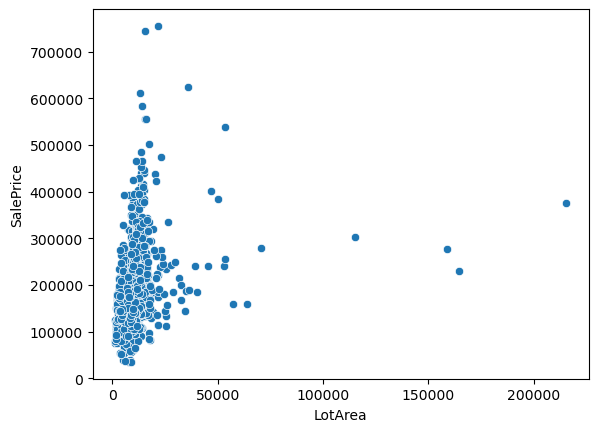

In [59]:
sns.scatterplot(data=df1, x='LotArea', y='SalePrice');

__DEALING WITH OUTLIERS__

1. 1-5 or 0-10 type numeric columns are not having outliers. Even if most of the data are between lets say 4-7, we will not assume 10 is outlier  

2. Some features we can think IQR3 is outliers and some columns we may not accept IQR5 outliers. We need to dive deep to each columns seperately

3. There are different ways to deal with outliers:  
        a. Detect and Remove them (Detection with zscore or IQR)
        b. Winsorization
        


In [12]:
class Outliers:
    def __init__(self, df, IQR_multi=3):
        self.df = df
        self.IQR_multi = IQR_multi

    def _get_outliers(self, col):
        Q1, Q3 = self.df[col].quantile([.25, .75])
        threshold_low = Q1 - self.IQR_multi * abs(Q1 - Q3)
        threshold_high = Q1 + self.IQR_multi * abs(Q1 - Q3)
        return (self.df[col] < threshold_low) | (self.df[col] > threshold_high)

    
    def detect_outlier_rows(self):
        outlier_rows = []
        self.df = self.df.select_dtypes(include='number')
        for col in self.df.columns:
            Q1, Q3 = self.df[col].quantile([.25, .75])
            threshold_low = Q1 - self.IQR_multi * abs(Q1-Q3)
            threshold_high = Q1 + self.IQR_multi * abs(Q1-Q3)
            is_outlier_exist = (self.df[col] < threshold_low) | (self.df[col] > threshold_high)
            outliers = self.df[is_outlier_exist]
            if not outliers.empty:
                outlier_rows.extend(outliers.index)
        outlier_rows = list(set(outlier_rows))  # Remove duplicates
        return self.df.iloc[outlier_rows]


    def detect_outlier_columns(self):
        outlier_features = []
        numeric_cols = self.df.select_dtypes(include='number').columns
        for col in numeric_cols:
            if self._get_outliers(col).any():
                outlier_features.append(col)
        return outlier_features

    def outlier_stats(self):
        outlier_stats = {'Feature': [], 'Negative Outliers': [], 'Positive Outliers': []}
        numeric_cols = self.df.select_dtypes(include='number').columns
        for col in numeric_cols:
            is_outlier = self._get_outliers(col)
            if is_outlier.any():
                outlier_stats['Feature'].append(col)
                outlier_stats['Negative Outliers'].append((is_outlier & (self.df[col] < self.df[col].median())).sum())
                outlier_stats['Positive Outliers'].append((is_outlier & (self.df[col] > self.df[col].median())).sum())
        return pd.DataFrame(outlier_stats)

In [13]:
outlier_handler = Outliers(df1, 3)

In [20]:
outlier_handler.outlier_stats()

,Feature,Negative Outliers,Positive Outliers
0,LotArea,0,54
1,OverallCond,1,22
2,BsmtFinSF1,0,3
3,BsmtFinSF2,0,167
4,BsmtUnfSF,0,6
5,TotalBsmtSF,0,11
6,1stFlrSF,0,9
7,GrLivArea,0,18
8,BsmtHalfBath,0,82
9,BedroomAbvGr,0,8


In [45]:
outlier_handler.outlier_stats()

,Feature,Negative Outliers,Positive Outliers
0,LotArea,0,54
1,OverallCond,1,22
2,BsmtFinSF1,0,3
3,BsmtFinSF2,0,167
4,BsmtUnfSF,0,6
5,TotalBsmtSF,0,11
6,1stFlrSF,0,9
7,GrLivArea,0,18
8,BsmtHalfBath,0,82
9,BedroomAbvGr,0,8


In [60]:
df1['LotArea'].corr(df1['SalePrice'])

0.26384335387140556

In [65]:
df1['sqmLotPrice'] = df1['SalePrice'] / df1['LotArea']

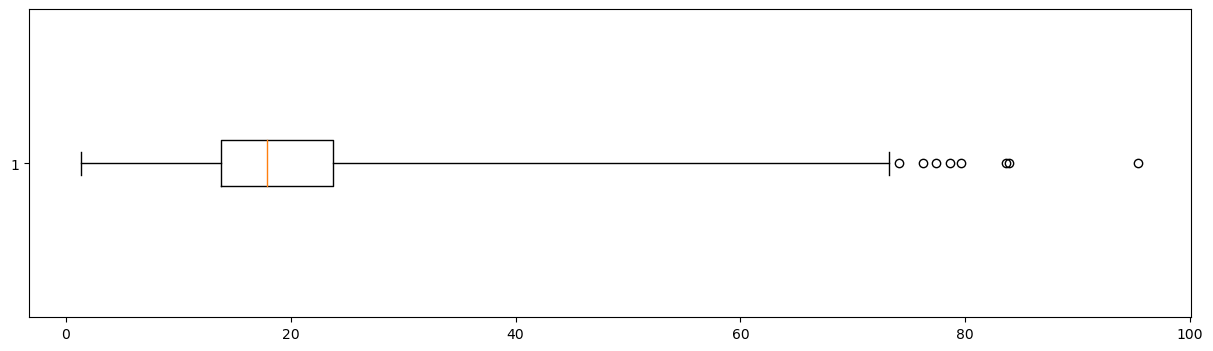

In [68]:
fig, axes = plt.subplots(figsize=(15,4))
axes.boxplot(df1.sqmLotPrice, vert=False, whis=5);

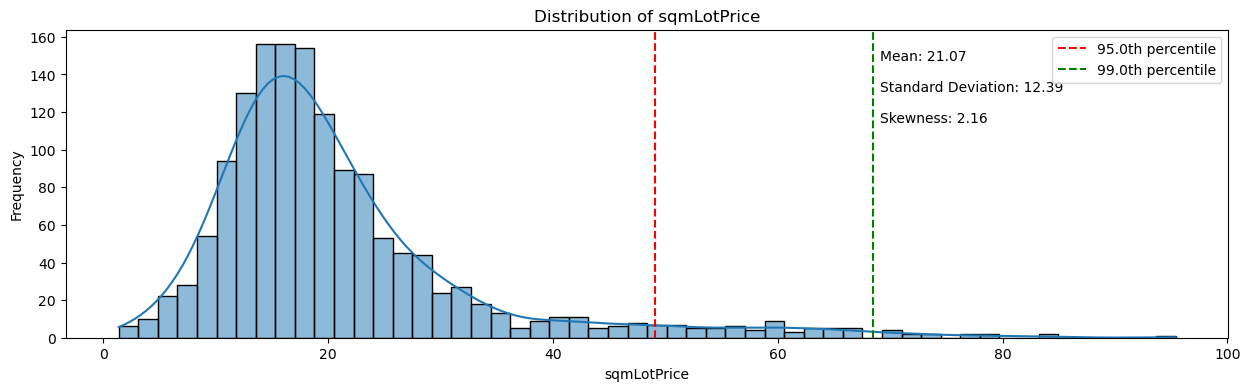

In [72]:
plot_dtl_hist(df1, 'sqmLotPrice', .95, .99)

In [74]:
outlier_handler=Outliers(df1, 5)

In [75]:
outlier_handler.outlier_stats()

,Feature,Negative Outliers,Positive Outliers
0,LotArea,0,24
1,BsmtFinSF1,0,1
2,BsmtFinSF2,0,167
3,TotalBsmtSF,0,1
4,1stFlrSF,0,1
5,GrLivArea,0,3
6,BsmtHalfBath,0,82
7,BedroomAbvGr,0,1
8,WoodDeckSF,0,1
9,OpenPorchSF,0,7


In [88]:
percentiles_lot_area = df1['LotArea'].quantile([.01, .99])

In [96]:
percentiles_lot_area

0.01     1680.00
0.99    37567.64
Name: LotArea, dtype: float64

In [95]:
df1[df1['LotArea'] > percentiles_lot_area[.99]][['Neighborhood', 'OverallQual', 'OverallCond', 'LotArea', 'SalePrice']]

,Neighborhood,OverallQual,OverallCond,LotArea,SalePrice
53,Veenker,9,5,50271,385000
249,ClearCr,6,7,159000,277000
271,ClearCr,7,7,39104,241500
313,Timber,7,5,215245,375000
335,Timber,5,6,164660,228950
384,ClearCr,6,5,53107,240000
451,ClearCr,7,5,70761,280000
457,ClearCr,4,6,53227,256000
523,Edwards,10,5,40094,184750
661,NoRidge,8,7,46589,402000
